In [1]:
! pip install opencv-python==3.4.11.45 
! pip install opencv-contrib-python==3.4.11.45 
! pip install tqdm

In [2]:
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from tqdm import tqdm
import time

import glob
import skimage.io
import skimage.transform

In [3]:
def show(img):
    io.imshow(img)
    plt.show()

In [4]:
#SIFT descriptors
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

#Stack the SIFT descriptors
def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

#Create Kmeans clusters for the descriptors
def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

#Extract features from the stacked descriptor and kmeans clusters
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
    return im_features

#Normalize the features for removal of outliers and better training
def normalizeFeatures(scale, features):
    return scale.transform(features)

#Plot histogram of features and sebsequent clusters
def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Traffic Signal Label")
    plt.ylabel("Frequency")
    plt.title("Complete Label to Frequency Ratio")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

#Create support vector machine model of features from training images
def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
        features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42)),
        5: (807 / (7 * 140)),
        6: (807 / (7 * 142)),
        7: (807 / (7 * 42)),
        8: (807 / (7 * 140)),
        9: (807 / (7 * 142))  
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

#Plot the confusion matrix that illustrates the false and true positive and negatives for each label
def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

#Show accuracy Score    
def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

In [5]:
#Load images from the path and return them with their labels as np arrays
def load_images(data_directory):
  
    # lists to store Images and labels
    images = []
    labels = []
    filesd = []
    # get list of all directories present in the data_directory path
    directories = [dir for dir in os.listdir(data_directory)
                 if os.path.isdir(os.path.join(data_directory,dir))] # to make sure that we include only directories and not any files present in the folder

    for dir in directories:
        current_directory = os.path.join(data_directory,dir)
        # Gather all fileNames in the given directory to load images into images array using sklearn
        file_names = [os.path.join(current_directory,file) 
                      for file in os.listdir(current_directory)
                      if file.endswith('.ppm')
                     ]
        filesd.append(file_names) 

        # Load all given Images into the Images array
        for file in file_names:
            images.append(skimage.io.imread(file))
            labels.append(int(dir))
    print('Successfully Loaded {0} images!'.format(len(images)))

    s = []
    for i in range(10):
        for j in range(100):
            s.append(filesd[i][j][30:50])
    arr =  np.array(s)  
    label = np.array(labels)
    label = label - 1
    return np.array(images),np.array(label),arr,len(directories)


#Load textfiles that have filenames for training and testing datasets
def load_txtfiles(data_directory):
    # lists to store Images and labels
    images = []
    labels = []    
    filesd = []
    # get list of all directories present in the data_directory path
    directories = [dir for dir in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory,dir))] # to make sure that we include only directories and not any files present in the folder

    for dir in directories:
        current_directory = os.path.join(data_directory,dir)
        # Gather all fileNames in the given directory to load images into images array using sklearn
        file_names = [os.path.join(current_directory,file)
                      for file in os.listdir(current_directory)
                      if file.endswith('.txt')
                     ]
        filesd.append(file_names)
    
    print("Successfully Loaded all train_test files")
    return np.array(filesd)


In [6]:
#Seperate test and training filenames into single np.arrays for better manipulation
def seperate_files(no_of_directories, filenames):
    test_filenames = []
    for q in range(no_of_directories):
        f = open(filenames[q][0], "r")    
        for x in f:
            x = x.rstrip("\n")
            test_filenames.append(x)
    #print((test_filenames))
    test_filenames = np.array(test_filenames)

    train_filenames = []
    for q in range(no_of_directories):
        f = open(filenames[q][1], "r")    
        for x in f:
            x = x.rstrip("\n")
            train_filenames.append(x)
    train_filenames = np.array(train_filenames)
    print('Training Set {0} file names!'.format(len(train_filenames)))
    print('Testing Set {0} file names!'.format(len(test_filenames)))
    return test_filenames,train_filenames

In [7]:
#using the train and test filenames split dataset of images and labels into Training and Testing Datasets
def seperate_train_test (images, labels, files, train_filenames,test_filenames):
    files2 = files.reshape(10,100)
    test_filenames2 = np.reshape(test_filenames, (10,20))
    train_filenames2 = train_filenames.reshape(10,80)

    qb=0
    qc=0
    rows = files2.shape[0] #10
    columns = files2.shape[1] #100
    columns2 = test_filenames2.shape[1] #20
    columns3 = train_filenames2.shape[1] #80


    testing_dataset = []
    training_dataset = []
    testing_dataset_images = []
    training_dataset_images = []
    testing_dataset_labels = []
    training_dataset_labels = []

    for q in range(rows): #10
        for k in range(columns): #100
            for w in range(columns2): #20
                if files2[q][k]==test_filenames2[q][w]:                
                    qb = qb+1
                    testing_dataset.append(files2[q][w])
                    testing_dataset_images.append(images[(q*100)+w])
                    testing_dataset_labels.append(labels[(q*100)+w])
            for w in range(columns3):
                if files2[q][k]==train_filenames2[q][w]:
                    qc = qc+1
                    training_dataset.append(files2[q][w])
                    training_dataset_images.append(images[(q*100)+w])
                    training_dataset_labels.append(labels[(q*100)+w])

    Train_dataset = np.array(training_dataset)
    Test_dataset  = np.array(testing_dataset)

    Train_dataset_images = np.array(training_dataset_images)
    Test_dataset_images = np.array(testing_dataset_images)

    Train_dataset_labels = np.array(training_dataset_labels)
    Test_dataset_labels = np.array(testing_dataset_labels)
    print("Train Test images seperated according to file name")
    return Train_dataset_images,Train_dataset_labels,Train_dataset,Test_dataset_images,Test_dataset_labels,Test_dataset

In [8]:
#Model for training the train dataset - SIFT Kmeans SVM classifier
def trainModel(images, labels, no_clusters, kernel):
    sift = cv2.SIFT_create()
    descriptor_list = []
    train_labels = labels
    label_count = 10
    image_count = len(images)

    for l in range(image_count):
        des = getDescriptors(sift, images[l])
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

In [9]:
#Test models with prediction and true values
def testModel(images, labels,kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = images#getFiles(False, path)

    count = 0
    true = labels
    descriptor_list = []
    image_count = len(images)

    sift = cv2.SIFT_create()
    
    name_dict =	{
        "0": 0,
        "1": 1,
        "2": 2,
        "3": 3,
        "4": 4,
        "5": 5,
        "6": 6,
        "7": 7,
        "8": 8,
        "9": 9
    }

    for l in range(image_count):
        des = getDescriptors(sift, images[l])
        if(des is not None):
            count += 1
            descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

Successfully Loaded 1000 images!
Successfully Loaded all train_test files
Training Set 800 file names!
Testing Set 200 file names!


<ipython-input-5-be756f4a186f>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images),np.array(label),arr,len(directories)
<ipython-input-7-ffcd49f3ceb2>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Train_dataset_images = np.array(training_dataset_images)
<ipython-input-7-ffcd49f3ceb2>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

Train Test images seperated according to file name
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


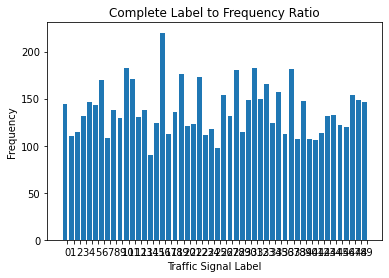

Features histogram plotted.
0.1 0.1
SVM fitted.
Training completed.
--- 104.22017073631287 seconds ---


In [10]:
[images,labels,files,no_of_directories] = load_images('CS893 Sp2022 A1 Dataset/')
filenames = load_txtfiles('CS893 Sp2022 A1 Dataset/')
[test_filenames,train_filenames] = seperate_files(no_of_directories, filenames)

[Train_dataset,Train_labels,Train_files,Test_dataset,Test_labels,Test_files] = seperate_train_test(images, labels, files, train_filenames,test_filenames)

no_clusters = 50
kernel = "precomputed"

begin = time.time()
[kmeans, scale, svm, im_features] = trainModel(Train_dataset, Train_labels, no_clusters, kernel)
end = time.time()
print("--- %s seconds ---" % (end - begin))

Test images classified.
Confusion matrix, without normalization
[[15  0  0  0  1  4  0  0  0  0]
 [ 0 19  1  0  0  0  0  0  0  0]
 [ 0  4 15  0  0  0  0  1  0  0]
 [ 0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0]
 [ 1  0  0  0  2 13  3  0  0  1]
 [ 0  0  0  1  3  1 14  0  0  1]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 2  0  0  0  1  2  0  0  0 15]]
Normalized confusion matrix
[[0.75 0.   0.   0.   0.05 0.2  0.   0.   0.   0.  ]
 [0.   0.95 0.05 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.2  0.75 0.   0.   0.   0.   0.05 0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.05 0.   0.   0.   0.1  0.65 0.15 0.   0.   0.05]
 [0.   0.   0.   0.05 0.15 0.05 0.7  0.   0.   0.05]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.1  0.   0.   0.   0.05 0.1  0.   0.   0.   0.75]]


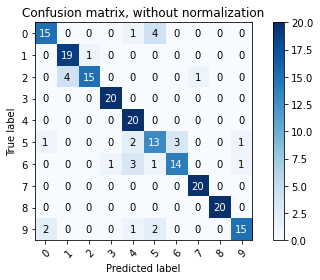

Confusion matrixes plotted.
accuracy score: 0.855
Accuracy calculated.
Execution done.
--- 9.000752925872803 seconds ---


In [11]:
begin = time.time()
testModel(Test_dataset,Test_labels, kmeans, scale, svm, im_features, no_clusters, kernel)
end = time.time()
print("--- %s seconds ---" % (end - begin))